In [1]:
# some notes
# P -> actual fraud
# N -> no fraud
# FN is the more dangerous ones we want to minimise
# FP is okay to deal with
# => recall is good metric to consider, F1 not so much
#
# it's usually hard to find data of an actual fraud
# P rate is low => skewed data
# 
# recall is TP / (TP+FN)

# that being said, F1 score is still nice to KIV

## part 0: loading

In [2]:
# packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.width', 1000)

In [3]:
# load data
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## part 1: EDA

In [4]:
print("shape:", df.shape)
print("columns:", df.columns.to_list())
print()

print("class distribution:")
print(df['Class'].value_counts())
print(f"fraud rate: {df['Class'].mean()*100:.4f}%") # dude that's just 0.17% damn
print()

print("quick stats")
print(df.describe())

# these are probably dimensionally reduced to something incomprehensible so no PII is compromised

shape: (284807, 31)
columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
fraud rate: 0.1727%

quick stats
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.175161e-15  3.384974e-16 -1.379537e-15  2.094852e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max   

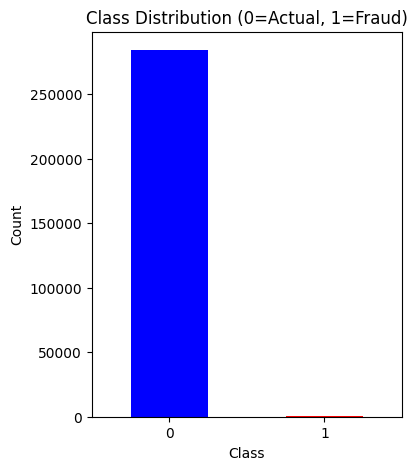

In [5]:
# visualising the imbalance
plt.figure(figsize=(4, 5))
df['Class'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Class Distribution (0=Actual, 1=Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# the red is so barely visible...
# clearly we need to do something about this

In [6]:
# check for missing values
print("missing values:")
print(df.isnull().sum().sum())

# oh! none! what luck!

missing values:
0


## part 2: data prep

the data is more or less cleaned, save for the class imbalance  
so that's the prep we gotta work  
  
we decided smote+tomek link  
because after some research this seems to give the best results  
reference [here](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset#11.-Combining-SMOTE-and-Tomek-Links)   
  
summary for self:  
The process of SMOTE-Tomek Links is as follows.  
1. Start of SMOTE: choose random data from the minority class.  
2. Calculate the distance between the random data and its k nearest neighbors.  
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.  
4. Repeat step number 2–3 until the desired proportion of minority class is met (End of SMOTE).  
5. Start of Tomek Links: choose random data from the majority class.  
6. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.

In [7]:
# train test split first!!
X = df.drop('Class', axis=1); y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [8]:
# dealing with imbalanced data
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
tomekU = TomekLinks()
smote_tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

## part 3: training models

### part 3.1: log reg unweighted

In [9]:
# scaling data first
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline, make_pipeline

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train); X_test_scale = scaler.fit_transform(X_test)

classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC AUC score: 0.9277699969739363:.4f



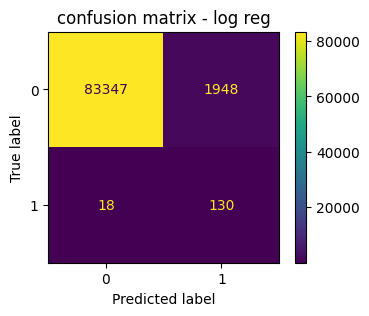

In [10]:
# good old log reg
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline

# adding smote & pred
logreg = LogisticRegression(random_state=40, max_iter=1000)
logreg_SMOTETomek_pipeline = make_pipeline(smote_tomek, logreg)
logreg_SMOTETomek_pipeline.fit(X_train_scale, y_train)
y_pred_logreg = logreg_SMOTETomek_pipeline.predict(X_test_scale)

# results
print("classification report")
print(classification_report(y_test, y_pred_logreg))
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_logreg)}:.4f")
print()

from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(4, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, ax=ax)
plt.title("confusion matrix - log reg")
plt.show()

# as expected it all looks a little too susp
# also the 57 FN is not looking great

### part 3.2: log reg weighted

"By assigning higher weights to the minority class and lower weights to the majority class, the model is encouraged to pay more attention to the minority class, thereby reducing the bias towards the majority class."  

[GeeksforGeeks](https://www.geeksforgeeks.org/machine-learning/weighted-logistic-regression-for-imbalanced-dataset/)
where i always go to rob code

classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.55     85443
weighted avg       1.00      0.98      0.99     85443

ROC AUC score: 0.9277699969739363:.4f



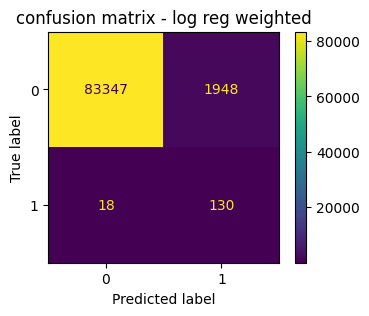

In [11]:
logreg_w = LogisticRegression(class_weight='balanced', random_state=40, max_iter=1000)
logreg_w_SMOTETomek_pipeline = make_pipeline(smote_tomek, logreg_w)
logreg_w_SMOTETomek_pipeline.fit(X_train_scale, y_train)
y_pred_logreg_w = logreg_w_SMOTETomek_pipeline.predict(X_test_scale)

# results
print("classification report")
print(classification_report(y_test, y_pred_logreg_w))
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_logreg_w)}:.4f")
print()

from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(4, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logreg, ax=ax)
plt.title("confusion matrix - log reg weighted")
plt.show()

### part 3.3: hyperparameter tuning for log reg

it appears that using weighted does not change very much after using smote & tomek did all the heavy lifting. let's get GridSearchCV to see if we can improve the model scoring abit more  

more info on gridsearch can be found [here](https://www.geeksforgeeks.org/machine-learning/how-to-optimize-logistic-regression-performance/) (ty once again to GeeksforGeeks) ((you can probably imagine how deeply concerned i was when google shut them down for that couple weeks))

update: this has been shelved because this is a speedrun and it's 12.14am and i need to sleep soon because of work (sadly). as suggested by the output:  
"Fitting 3 folds for each of 1600 candidates, totalling 4800 fits"  
this amount time totals to 320h which is WILD. so i'm skipping that.

In [12]:
# from sklearn.model_selection import GridSearchCV

# paramGrid = [
#     {
#         'penalty':['l1','l2','elasticnet','none'],
#         'C' : np.logspace(-4,4,20),
#         'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
#         'max_iter'  : [100,1000,2500,5000]
#     }
# ]

# tuning = GridSearchCV(logreg, param_grid=paramGrid, cv=3, verbose=True, n_jobs=-1)

# logreg_best_SMOTETomek_pipeline = make_pipeline(smote_tomek, tuning)
# logreg_best_SMOTETomek_pipeline.fit(X_train_scale, y_train)
# print(logreg_best_SMOTETomek_pipeline.best_estimator_)
# print()

# y_pred_best_logreg = logreg_best_SMOTETomek_pipeline.predict(X_test_scale)

# # results
# print("classification report")
# print(classification_report(y_test, y_pred_best_logreg))
# print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_best_logreg)}:.4f")
# print()

# from sklearn.metrics import ConfusionMatrixDisplay
# fig, ax = plt.subplots(figsize=(4, 3))
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best_logreg, ax=ax)
# plt.title("confusion matrix - log reg weighted")
# plt.show()

### part 3.4: random forest

classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.87      0.80      0.83       148

    accuracy                           1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC AUC score: 0.8985489945071398:.4f



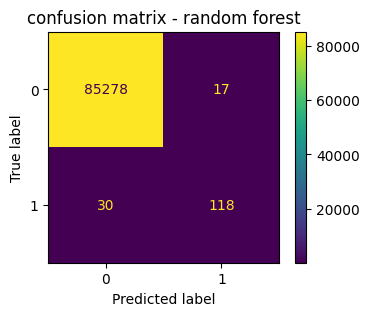

In [13]:
from sklearn.ensemble import RandomForestClassifier

twees = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1)
rf_SMOTETomek_pipeline = make_pipeline(smote_tomek, twees)
rf_SMOTETomek_pipeline.fit(X_train, y_train)
y_pred_rf = rf_SMOTETomek_pipeline.predict(X_test)

# results
print("classification report")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_rf)}:.4f")
print()

from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(4, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax)
plt.title("confusion matrix - random forest")
plt.show()

### part 3.5: XGBoost

scale pos weight (imbalance ratio): 578.5


c:\Users\ameli\Documents\credit card fraud detection\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [00:39:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


classification report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.14      0.86      0.24       148

    accuracy                           0.99     85443
   macro avg       0.57      0.92      0.62     85443
weighted avg       1.00      0.99      0.99     85443

ROC AUC score: 0.9244347914947012:.4f



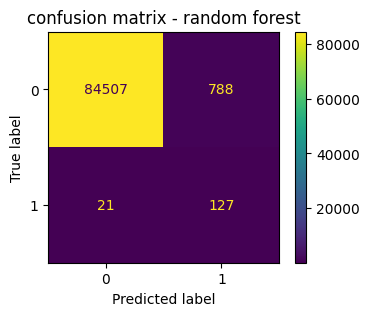

In [14]:
import xgboost as xgb

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale pos weight (imbalance ratio): {scale_pos_weight:.1f}")

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    eval_metric='aucpr',  # Area under precision-recall curve
    random_state=39,
    use_label_encoder=False  # Suppress warning
)
xgb_SMOTETomek_pipeline = make_pipeline(smote_tomek, xgb_model)
xgb_SMOTETomek_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_SMOTETomek_pipeline.predict(X_test)

print("classification report")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_xgb)}:.4f")
print()

from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(4, 3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, ax=ax)
plt.title("confusion matrix - random forest")
plt.show()

## part 4: assessing all the models

           Model  Precision   Recall  F1-Score  ROC-AUC
         Log Reg   0.062560 0.878378  0.116801 0.927770
Log Reg Weighted   0.062560 0.878378  0.116801 0.927770
   Random Forest   0.874074 0.797297  0.833922 0.898549
         XGBoost   0.138798 0.858108  0.238946 0.924435


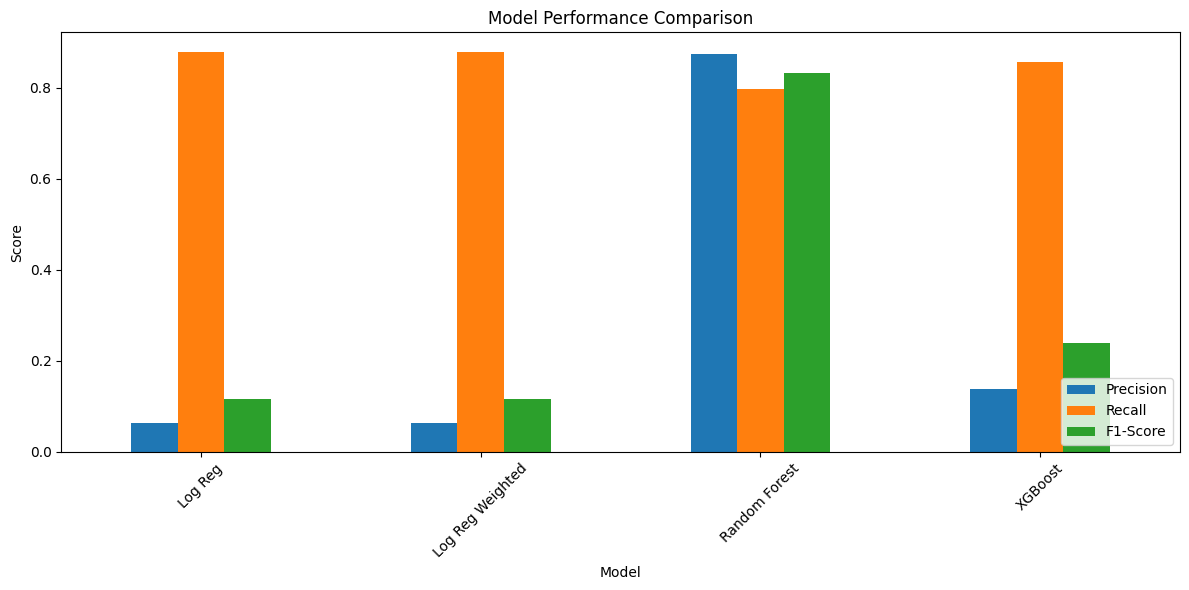

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

mdls = ['Log Reg', 'Log Reg Weighted', 'Random Forest', 'XGBoost']
preds = [y_pred_logreg, y_pred_logreg_w, y_pred_rf, y_pred_xgb]

tbl = pd.DataFrame({
    'Model': mdls,
    'Precision': [precision_score(y_test, pred) for pred in preds],
    'Recall': [recall_score(y_test, pred) for pred in preds],
    'F1-Score': [f1_score(y_test, pred) for pred in preds],
    'ROC-AUC': [roc_auc_score(y_test, pred) for pred in preds]
})

print(tbl.to_string(index=False))

# Visualize
tbl.plot(x='Model', y=['Precision', 'Recall', 'F1-Score'], kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### some quick observations to be found
we have a common theme going on here: the recall is god level high, and reasonably so. Because the amount of data we have on class: 1 (frauds) are so insanely little, as long as the amount of FN is proportionally lower than TP, its easy to score well.  

WHEREAS, on the other hand, we have the shattering reality that which is precision, which slaps us into reality. Because precision some what leverages the HORDE of negatives present in the data, we get an overly hard slap in the face, with tragically low scoring.  

The one that presents the best balance would be random forest, rather obviously shown by the bar graph. Even though the recall score is the lowest among the 4, the fact that precision is high scoring as well is a sign that it is minimally affected by the data imbalance.

Hence, in this speedrun, by final model would be Random Forest.

### steps moving forward
ah yes! so much i didn't do!  
There are other kaggle notebooks with high-scoring XGBoost models, unlike mine and its most likely because of my lack of hyperparam tuning. but in limited time constraints, i learnt that hyperparam tuning is something that needs many hours and days to perfect.

Hence, to improve models moving forward, I'd probably take the XGB and RF on to use GridSearchCV or any better hyperparameter tuning packages out there. Hypothetically speaking, that should boost the models significantly and further conclusions can be drawn then.

Until next time!